In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [2]:
# creo una funzione utilizzando l'endpoint per ricavare i dati contenuti nelle tabelle del mio db.
# passo dunque un json contenente il nome della tabella e creo un dataframe con i dati ottenuti dalla response
def import_dati_da_db(url, json_data):
    try:
        response = requests.post(url, json=json_data)
        # controllo sulla response
        if response.status_code == 200:
            json_response = response.json()
            df = pd.DataFrame(json_response["data"])
            #eseguo subito il drop della colonna id visto che non serve
            df = df.drop(['id'], axis=1)
            return df  
        else:
            print(f"errore durante la request: {response.status_code}")
            return None
    except Exception as e:
        print(f"errore: {str(e)}")
        return None

In [3]:
# creazione df per analisi usando la funzione definita nel blocco di sopra
url = "http://localhost:8000/get"
json_vini_rossi = {
    "table_name" : "dati_vini_rossi"
}
json_vini_bianchi = {
    "table_name" : "dati_vini_bianchi"
}
df_vini_rossi = import_dati_da_db(url, json_vini_rossi)
print(df_vini_rossi) 

df_vini_bianchi = import_dati_da_db(url, json_vini_bianchi)
print(df_vini_bianchi) 

# Per l'analisi EDA, unisci i due dataframe in un unico dataframe aggiungendo la categoria del vino per ogni record.
# aggiungo la categoria per i vini
df_vini_rossi['category']='red'
df_vini_bianchi['category']='white'

df_vini = pd.concat([df_vini_rossi, df_vini_bianchi], ignore_index=True)

print(df_vini)

      fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0               7.4             0.700         0.00             1.9      0.076   
1               7.8             0.880         0.00             2.6      0.098   
2               7.8             0.760         0.04             2.3      0.092   
3              11.2             0.280         0.56             1.9      0.075   
4               7.4             0.700         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
1594            6.2             0.600         0.08             2.0      0.090   
1595            5.9             0.550         0.10             2.2      0.062   
1596            6.3             0.510         0.13             2.3      0.076   
1597            5.9             0.645         0.12             2.0      0.075   
1598            6.0             0.310         0.47             3.6      0.067   

      free_sulfur_dioxide  

In [4]:
# funzioni DATAVIZ
def corr_map (corr_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True)
    plt.show()

def box_plots(data: pd.DataFrame):
    num_columns = data.shape[1]
    num_rows = (num_columns - 1) // 3 + 1
    num_cols = min(num_columns, 3)

    plt.figure(figsize=(15, 12))

    for n, col in enumerate(data.columns, start=1):
        plt.subplot(num_rows, num_cols, n)
        sns.boxplot(data[col])
        plt.title(col)

    plt.tight_layout()
    plt.show()

In [5]:
# Funzioni per pulizia dati
def iqr_range (df, colonna):
    if colonna not in df.columns:
        print(f"La colonna '{colonna}' non esiste nel DataFrame.")
        return

    q1 = df[colonna].quantile(0.25)
    q3 = df[colonna].quantile(0.75)
    iqr = q3 - q1


    low_limit = q1 - 1.5 * iqr
    up_limit = q3 + 1.5 * iqr

    # in questo modo limito i valori al limite inferiore ed al limite superiore definito in precedenza
    df.loc[df[colonna] > up_limit, colonna] = up_limit
    df.loc[df[colonna] < low_limit, colonna] = low_limit

    return df

fixed_acidity           False
volatile_acidity        False
citric_acid             False
residual_sugar          False
chlorides               False
free_sulfur_dioxide     False
total_sulfur_dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
category                False
dtype: bool


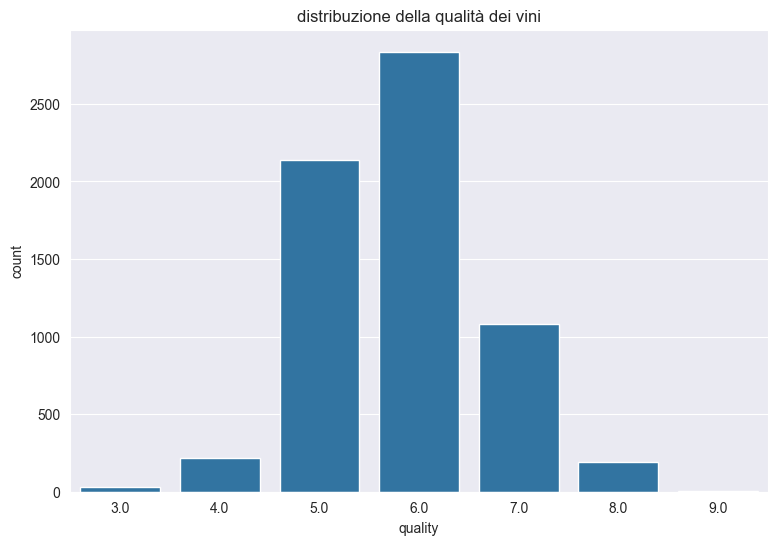

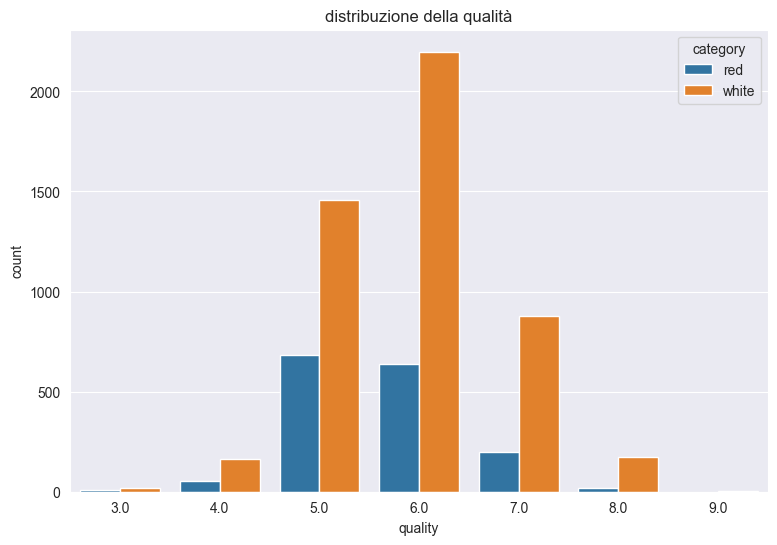

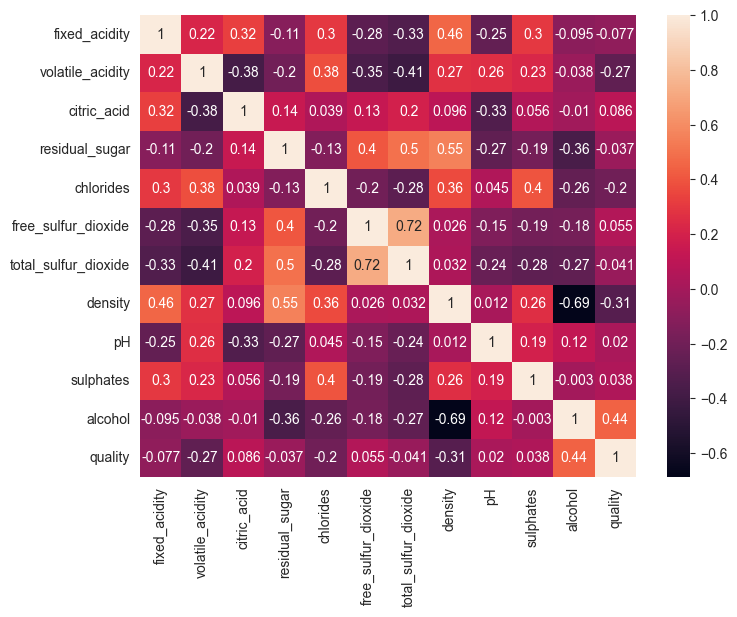

Boxplot prima dell'analisi


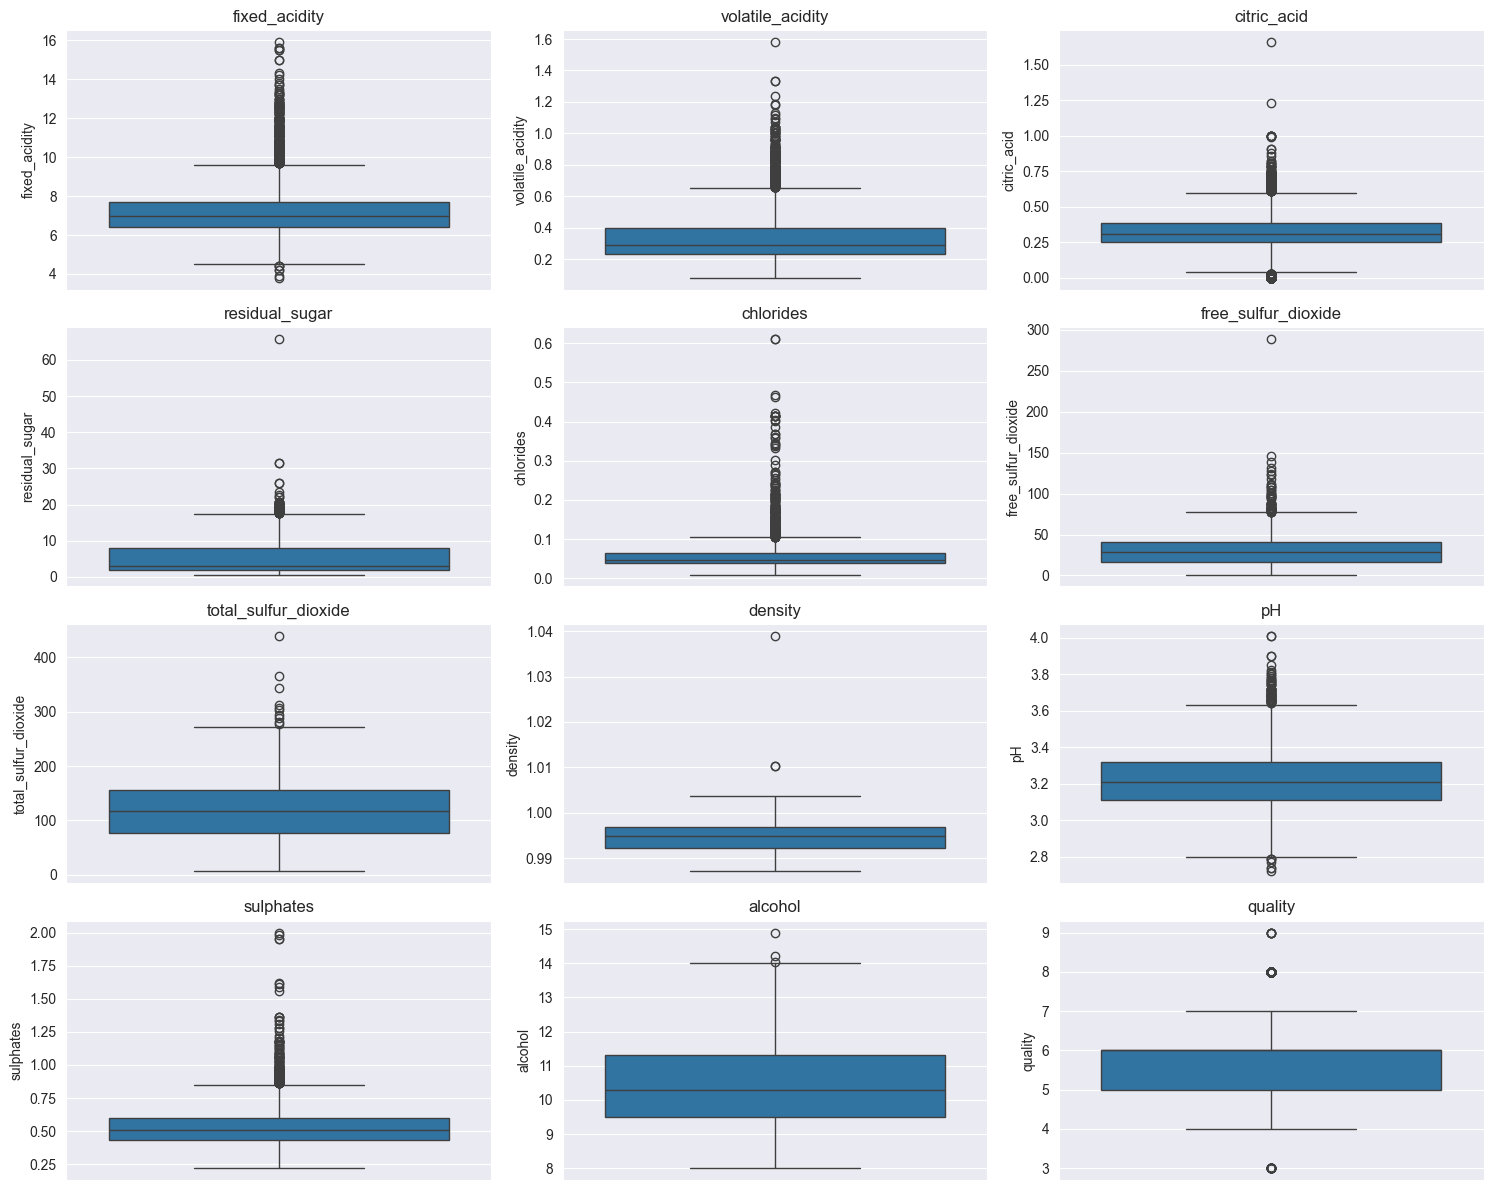

Boxplot dopo l'applicazione dell'iqr_range


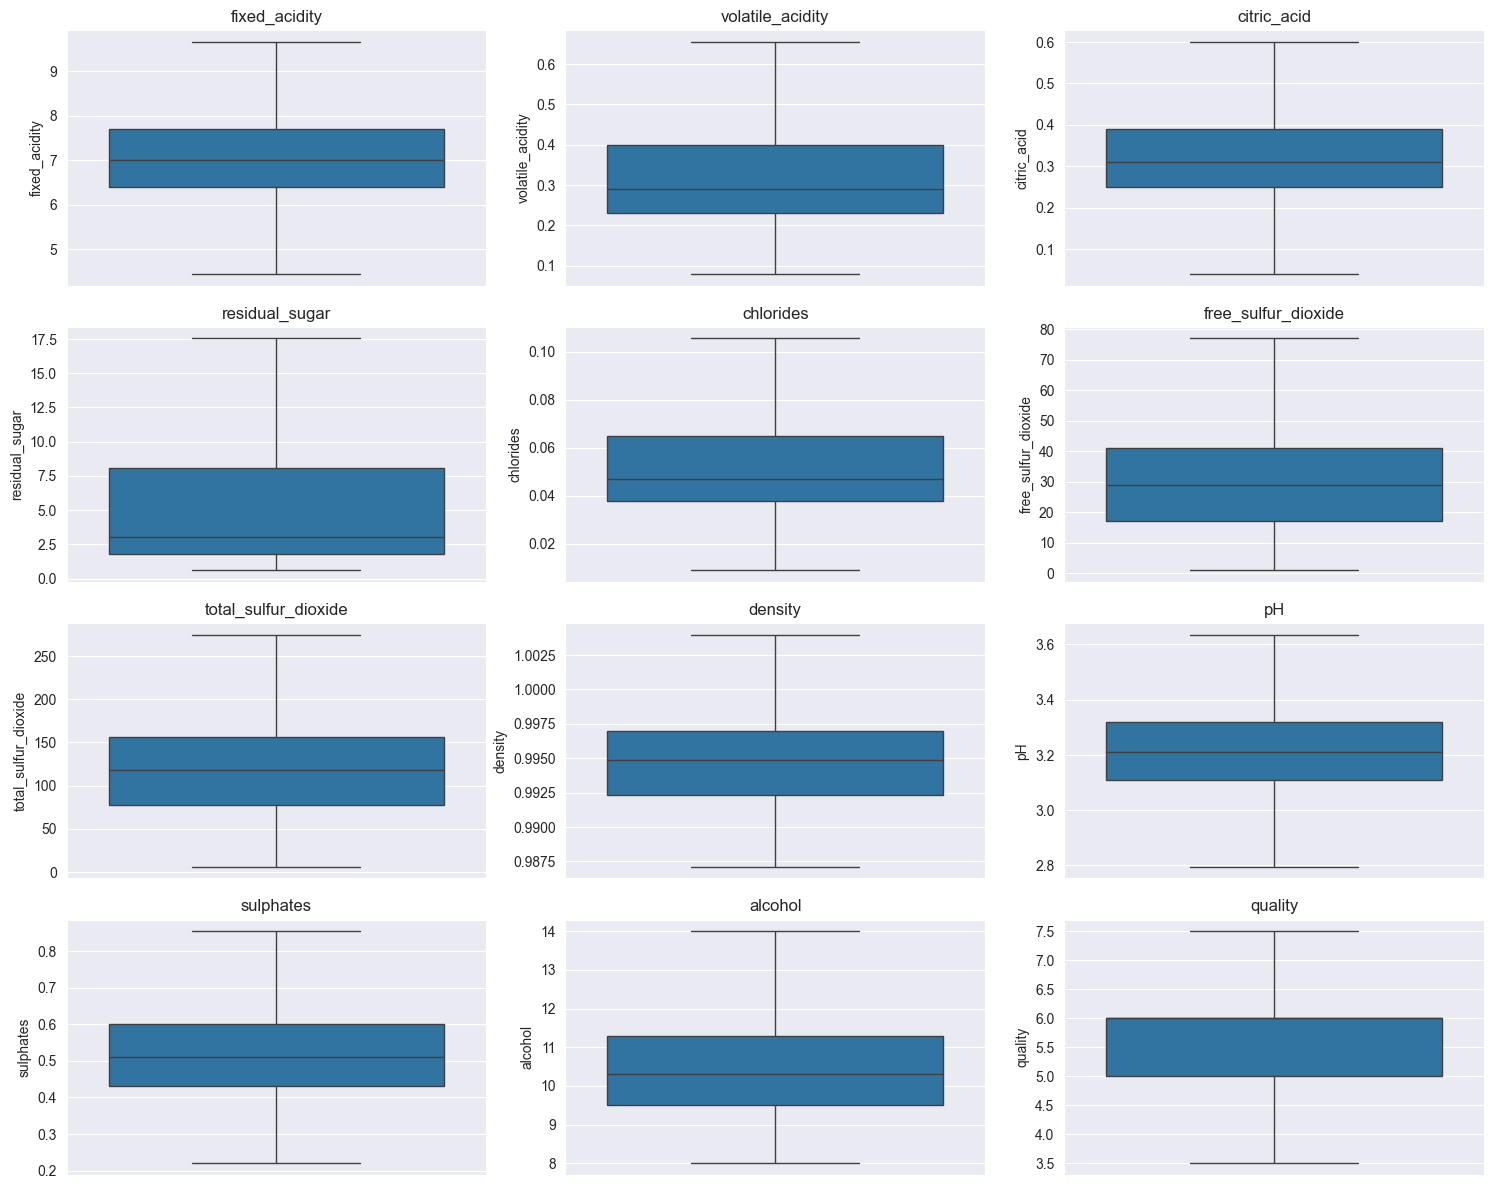

In [6]:
# FASE DI ANALISI
# per prima cosa controllo la presenza di valori nulli nel df anche se dal documento risulta che non ce ne siano
print(df_vini.isnull().any())

# controllo la presenza di eventuali outlier. Dal documento descrittivo risulta una scarsa presenza di vini eccellenti e di vini scadenti ma potrebbero comunque influire sui risultati del modello
# 1) controllo della distribuzione della qualità
plt.figure(figsize=(9,6))
sns.countplot(data=df_vini,x='quality')
plt.title("distribuzione della qualità dei vini")
plt.show()
# come descritto dal documento, si può notare che la maggior parte dei vini siano di qualità media

# analizzo la distribuzione della qualità del vino in base al colore
# da questo grafico inoltre, si può notare la disparità tra vini rossi e vini bianchi nel df
figure = plt.figure(figsize = (9,6))
ax = sns.countplot(x = "quality", hue = "category", data = df_vini)
plt.title("distribuzione della qualità")
plt.show()

# creo un df dei vini senza categorie
df_vini_no_cat = df_vini.copy()
df_vini_no_cat = df_vini_no_cat.drop(['category'], axis=1)
# display(df_vini_no_cat)

# 2) visualizzo la correlazione tra le variabili
corr_matrix = df_vini_no_cat.corr()
corr_map(corr_matrix)

# 3) verifico la presenza di outliers nel df
# da vedere se c'è qualche colonna che si può eliminare
print( "Boxplot prima dell'analisi")
box_plots(df_vini_no_cat)

# applico il limite le range interquartile per eliminare gli outlier
print("Boxplot dopo l'applicazione dell'iqr_range")
for colonna in df_vini_no_cat.columns:
  df_vini_no_cat = iqr_range(df_vini_no_cat, colonna)
box_plots(df_vini_no_cat)

In [7]:
# come si può vedere dalla mappa di correlazione, ciò che sembra influire di più sulla qualità del vino è la quantità presente di alcohol
# attributi come la densità e la volatile acidity sembrano essere poco correlati alla qualità del vino e si potrebbero eliminare.
df_vini_no_cat = df_vini_no_cat.drop(['density'], axis=1)
df_vini_no_cat = df_vini_no_cat.drop(['volatile_acidity'], axis=1)

# si potrebbe anche eliminare la colonna total sulfur dioxide visto che presenta un'alta correlazione con la free sulphur dioxide. Potrebbe verificarsi una ridondanza dei dati
df = df_vini_no_cat.drop('total sulfur dioxide', axis=1)
print(df_vini_no_cat)

KeyError: "['total sulfur dioxide'] not found in axis"

In [ ]:
# visualizziamo la dstribuzione dei dati del dataset
# come si può vedere ora abbiamo  dei dati più omogenei
df_vini_no_cat.hist(bins=20, figsize=(10, 10))
plt.show()

In [ ]:
def test_model(model, x, y):

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

    x_train = x_train.reshape(-1,1)
    y_train = y_train.reshape(-1,1)

    model.fit(x_train, y_train)

    x_test = x_test.reshape(-1,1)

    y_pred = model.predict(x_test)


    # [4] error
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    scores_df = pd.DataFrame({'rmse': [np.sqrt(mse)], 'r2': [r2]})

    print(f'predizioni: {y_pred}')

    return y_pred, y_test, mse, r2

In [ ]:
x = df_vini_no_cat.drop('quality', axis=1)
y = df_vini_no_cat['quality']

model = LinearRegression()
y_pred, y_test, mse, r2 = test_model(model, x, y)

print("Dimensione di t_rpre:", y_pred.shape)
print("Dimensione di y_test:", y_test.shape)

print(r2)
print(mse)


